# Wuhan Corona Virus Outbreak

- webscraped infected counts from national health commision via wikipedia
- infection counts are fitted to a simple exponential distribution 


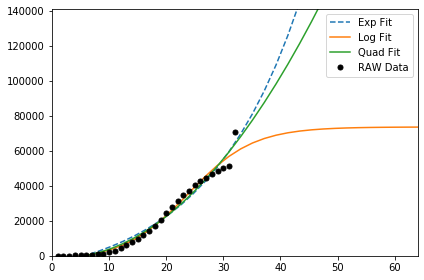

11370.19578570605 0.06113326029285198 -16088.813516036595
76391.13030887807 23.821120015077838 0.176989730072497 -2831.885297165014
70.61788964134556 244.57602531534886 -912.6723790342531


In [87]:
import requests
import lxml.html as lh
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from bs4 import BeautifulSoup

%matplotlib inline

url = 'https://en.wikipedia.org/wiki/2019%E2%80%9320_Wuhan_coronavirus_outbreak'
page = requests.get(url).text
soup = BeautifulSoup(page,'lxml')
#print(soup.prettify())
My_table = soup.find('div',{'class':'barbox tright'})

datesfinal = []
countsfinal = []

dates = My_table.findAll('td', style='padding-right:0.4em; padding-left:0.4em; width:auto')

for date in dates[1:]:
    datesfinal.append((pd.to_datetime(date.get_text())))
    
counts = My_table.findAll('td', colspan = '2', style='padding-left:0.4em; text-align:left; width:auto;')

'''
#Old Methods (changed because Wikipedia updates)
for count in counts:
    countsfinal.append(int(count.get_text()[0:count.get_text().find('(')].replace(',',''))) 


for count in counts:
    if count.get_text().find('/') == -1:
        countsfinal.append(int(count.get_text()[0:count.get_text().find('(')].replace(',',''))) 
    else: 
        countsfinal.append(int(count.get_text()[count.get_text().find('/')+1:count.get_text().find('(')].replace(',',''))) 
'''
for count in counts[1:]:
        countsfinal.append(int(count.get_text().rstrip().lstrip()[0:count.get_text().rstrip().lstrip().find('\n')].replace(',','')))

d=list(zip(datesfinal, countsfinal))
df=pd.DataFrame(data=d, columns=['Date','Infected'])    

def exponential_fit(x, a, b, c):
    return a*np.exp(b*x) + c

#sigmoid is special case of logistic function whereas:
# L = 1, k = 1, X0 = 0
# ref: https://stats.stackexchange.com/questions/204484/what-are-the-differences-between-logistic-function-and-sigmoid-function
'''
def sigmoidal_fit(x, k, x0):
    return (1 / (1 + np.exp(-k*(x-x0))))
'''

def logistic_fit(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y)

def quadratic_fit(x, a, b, c):
    y = a*(x**2) - (b*x) + c
    return (y)

def tanh_fit(x, eta=1, phi=1):
    y = np.tanh(eta * (x + phi))
    return (y)

x = np.linspace(1,len(df),len(df))
y = np.array(df['Infected'])

# Exponential Fit
fitting_parameters_exp, covariance_exp = curve_fit(exponential_fit, x, y)
a, b, c = fitting_parameters_exp
'''
# Sigmoidal Fit
fitting_parameters_sig, covariance_sig = curve_fit(sigmoidal_fit, x, y, method='dogbox')
a1, b1 = fitting_parameters_sig
'''
# Logistic Fit
p0 = [max(y), np.median(x),1,min(y)] # this is an mandatory initial guess
fitting_parameters_log, covariance_log = curve_fit(logistic_fit, x, y,p0, method='dogbox')
a2, b2, c2, d2 = fitting_parameters_log

# Quadratic Fit
fitting_parameters_quad, covariance_quad = curve_fit(quadratic_fit, x, y)
a3, b3, c3 = fitting_parameters_quad

# Tanh Fit (WIP)
#fitting_parameters_tanh, covariance_tanh = curve_fit(tanh_fit, x, y)
#a4, b4 = fitting_parameters_tanh

x_min = 0 
x_max = len(df)*2
x_fit = np.linspace(x_min, x_max, len(df)) 

plt.plot(x_fit, exponential_fit(x_fit, *fitting_parameters_exp), '--', label='Exp Fit')
# plt.plot(x_fit, sigmoidal_fit(x_fit, *fitting_parameters_sig), '-', label='Sig Fit')
plt.plot(x_fit, logistic_fit(x_fit, *fitting_parameters_log), '-', label='Log Fit')
plt.plot(x_fit, quadratic_fit(x_fit, *fitting_parameters_quad), '-', label='Quad Fit')
#plt.plot(x_fit, tanh_fit(x_fit, *fitting_parameters_tanh), '-', label='Tanh Fit')


plt.plot(x, y, '.', label='RAW Data', color='k', markersize=10)

plt.plot(title='Wuhan')
plt.ylim(0, max(df['Infected'])*2)
plt.xlim(0,len(df)*2)
plt.tight_layout()
plt.legend()

plt.show()

print(a,b,c)
#print(a1,b1)
print(a2,b2,c2,d2)
print(a3,b3,c3)


In [89]:
print(curve_fit(exponential_fit, x, y))
print(curve_fit(logistic_fit, x, y))
print(curve_fit(quadratic_fit, x, y))



(array([ 1.13701958e+04,  6.11332603e-02, -1.60888135e+04]), array([[ 1.13838158e+07, -2.69043934e+01, -1.54750805e+07],
       [-2.69043934e+01,  6.42562878e-05,  3.60512217e+01],
       [-1.54750805e+07,  3.60512217e+01,  2.18085653e+07]]))
(array([ 7.63908775e+04,  2.38210829e+01,  1.76990372e-01, -2.83186144e+03]), array([[ 9.73379732e+07,  1.21381015e+04, -2.63945737e+02,
        -1.38376909e+07],
       [ 1.21381015e+04,  1.76777115e+00, -3.11681779e-02,
        -1.18458448e+03],
       [-2.63945737e+02, -3.11681779e-02,  7.94749327e-04,
         4.32083416e+01],
       [-1.38376909e+07, -1.18458448e+03,  4.32083416e+01,
         3.43896998e+06]]))
(array([  70.61788964,  244.57602532, -912.67237903]), array([[4.63494635e+01, 1.52953234e+03, 8.66735024e+03],
       [1.52953234e+03, 5.36263325e+04, 3.38026665e+05],
       [8.66735024e+03, 3.38026665e+05, 2.74754999e+06]]))
